In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import shap


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML PROJECTS/2. Bank Loan Classification/loan.csv')
df.head()

<ipython-input-5-c04b44df6351>:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/ML PROJECTS/2. Bank Loan Classification/loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(39717, 111)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [ ]:
df.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [ ]:
df = df.loc[:, df.apply(lambda column: column.nunique() > 1)]
df.dropna(axis=1, thresh=0.8 * df.shape[0], inplace=True)
df.drop(columns=df.columns[df.nunique() / len(df) * 100 > 60], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39717 non-null  int64  
 1   funded_amnt              39717 non-null  int64  
 2   funded_amnt_inv          39717 non-null  float64
 3   term                     39717 non-null  object 
 4   int_rate                 39717 non-null  object 
 5   installment              39717 non-null  float64
 6   grade                    39717 non-null  object 
 7   sub_grade                39717 non-null  object 
 8   emp_length               38642 non-null  object 
 9   home_ownership           39717 non-null  object 
 10  annual_inc               39717 non-null  float64
 11  verification_status      39717 non-null  object 
 12  issue_d                  39717 non-null  object 
 13  loan_status              39717 non-null  object 
 14  purpose               

In [ ]:
df.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                 1075
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
title                        11
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   50
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_rec_prncp               0
total_rec_late_fee            0
recoveri

In [ ]:
cols_to_remove = ["issue_d","last_credit_pull_d","last_pymnt_d","pub_rec_bankruptcies","earliest_cr_line","addr_state","sub_grade","zip_code",'title']
df.drop(labels= cols_to_remove,axis=1,inplace=True)


In [ ]:
df['revol_util']=df['revol_util'].str.rstrip('%')
df['revol_util'].fillna(0, inplace=True)
df['revol_util'] = pd.to_numeric(df['revol_util'], errors='coerce')

In [ ]:
df.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_length                 1075
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_rec_prncp               0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
dtype: int64

In [ ]:
def map_emp_length(emp_length):
    if emp_length in ['< 1 year', '1 year', '2 years']:
        return 1
    elif emp_length in ['3 years', '4 years', '5 years']:
        return 2
    elif emp_length in ['6 years', '7 years', '8 years', '9 years', '10 years']:
        return 3
    elif emp_length == '10+ years':
        return 4
    else:
        return None

df['emp_length'] = df['emp_length'].apply(map_emp_length)
print(df['emp_length'].value_counts())

emp_length
1.0    12211
2.0    10813
4.0     8879
3.0     6739
Name: count, dtype: int64


In [ ]:
df['emp_length'].fillna(0, inplace=True)
df['emp_length'].value_counts()

emp_length
1.0    12211
2.0    10813
4.0     8879
3.0     6739
0.0     1075
Name: count, dtype: int64

In [ ]:
df['int_rate']=df['int_rate'].str.rstrip('%')

In [ ]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [ ]:
label_encoder = LabelEncoder()
df['term'] = label_encoder.fit_transform(df['term'])
df['grade'] = label_encoder.fit_transform(df['grade'])
df['home_ownership'] = label_encoder.fit_transform(df['home_ownership'])
df['verification_status'] = label_encoder.fit_transform(df['verification_status'])
df['purpose'] = label_encoder.fit_transform(df['purpose'])
df['loan_status'] = label_encoder.fit_transform(df['loan_status'])

In [ ]:
new_var = df[df['loan_status'] != 1]
df = new_var

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['loan_status']),df['loan_status'],test_size = 0.2)

In [ ]:
y_train.value_counts()

loan_status
2    26358
0     4503
Name: count, dtype: int64

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
y_train_resampled.value_counts()

loan_status
2    26358
0    26358
Name: count, dtype: int64

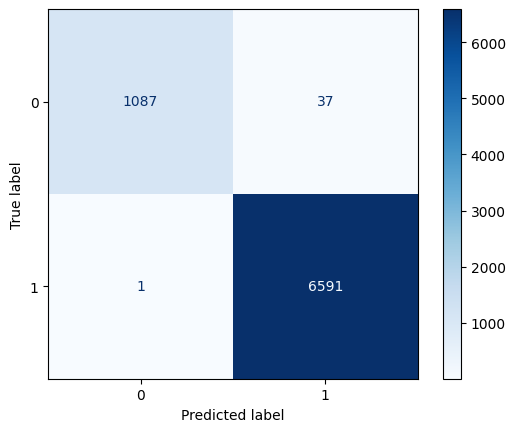

Random Forest Accuracy: 1.00


In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

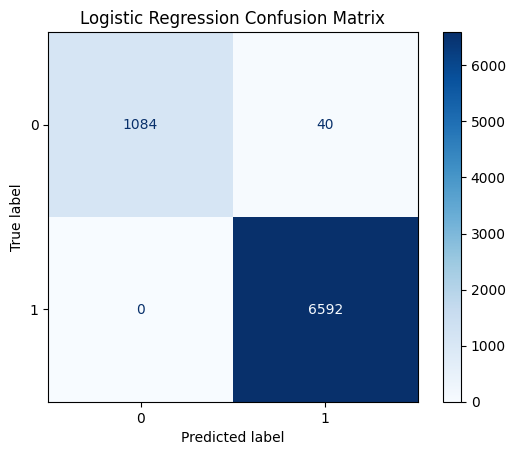

Logistic Regression Accuracy: 0.99
Top 10 Features for Logistic Regression: Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment',
       'annual_inc', 'verification_status', 'total_rec_prncp', 'recoveries',
       'collection_recovery_fee'],
      dtype='object')


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Logistic Regression with RFE
lr_model = LogisticRegression(random_state=42)
rfe_lr = RFE(estimator=lr_model, n_features_to_select=10)
rfe_lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = rfe_lr.predict(X_test)

# Confusion Matrix and Accuracy
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix")
plt.show()
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")

# Top 10 Features
top_features_lr = rfe_lr.support_
print("Top 10 Features for Logistic Regression:", X_train_resampled.columns[top_features_lr])

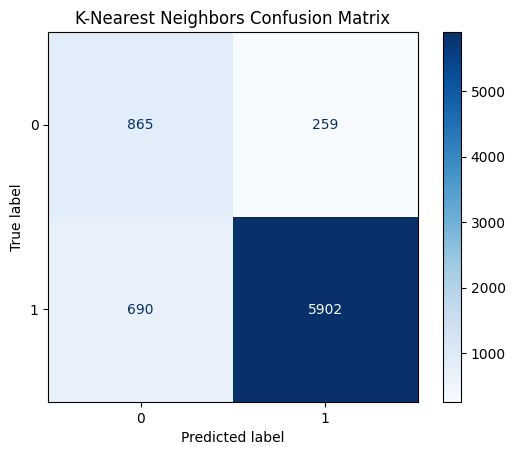

K-Nearest Neighbors Accuracy: 0.88
Top 10 Features for K-Nearest Neighbors: Index(['term', 'int_rate', 'grade', 'annual_inc', 'inq_last_6mths',
       'revol_util', 'total_rec_prncp', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee'],
      dtype='object')


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# K-Nearest Neighbors with SelectKBest
skb_knn = SelectKBest(score_func=f_classif, k=10)
X_train_knn = skb_knn.fit_transform(X_train_resampled, y_train_resampled)
X_test_knn = skb_knn.transform(X_test)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_knn, y_train_resampled)
y_pred_knn = knn_model.predict(X_test_knn)

# Confusion Matrix and Accuracy
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("K-Nearest Neighbors Confusion Matrix")
plt.show()
print(f"K-Nearest Neighbors Accuracy: {accuracy_score(y_test, y_pred_knn):.2f}")

# Top 10 Features
top_features_knn = skb_knn.get_support()
print("Top 10 Features for K-Nearest Neighbors:", X_train_resampled.columns[top_features_knn])


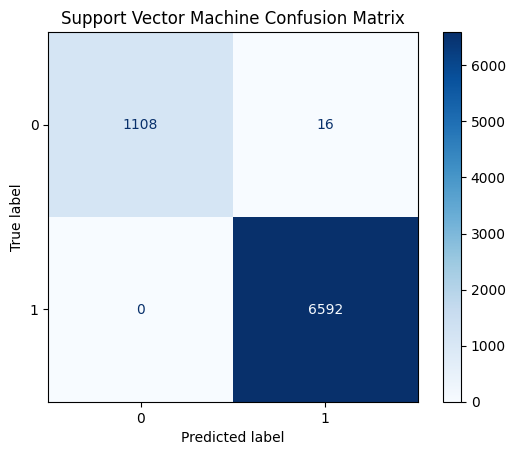

Support Vector Machine Accuracy: 1.00
Top 10 Features for Support Vector Machine: Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment',
       'grade', 'annual_inc', 'total_rec_prncp', 'recoveries',
       'collection_recovery_fee'],
      dtype='object')


In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# Support Vector Machine with RFE
svm_model = SVC(kernel="linear", random_state=42)
rfe_svm = RFE(estimator=svm_model, n_features_to_select=10)
rfe_svm.fit(X_train_resampled, y_train_resampled)
y_pred_svm = rfe_svm.predict(X_test)

# Confusion Matrix and Accuracy
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title("Support Vector Machine Confusion Matrix")
plt.show()
print(f"Support Vector Machine Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")

# Top 10 Features
top_features_svm = rfe_svm.support_
print("Top 10 Features for Support Vector Machine:", X_train_resampled.columns[top_features_svm])


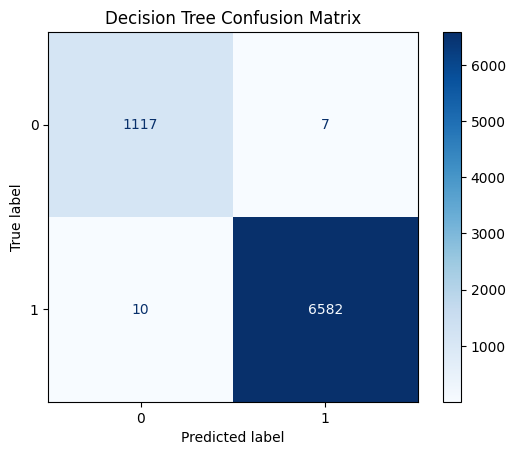

Decision Tree Accuracy: 1.00
Top 10 Features for Decision Tree: Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'home_ownership', 'annual_inc', 'dti', 'total_rec_prncp',
       'total_rec_late_fee', 'recoveries'],
      dtype='object')


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

# Decision Tree with RFE
dt_model = DecisionTreeClassifier(random_state=42)
rfe_dt = RFE(estimator=dt_model, n_features_to_select=10)
rfe_dt.fit(X_train_resampled, y_train_resampled)
y_pred_dt = rfe_dt.predict(X_test)

# Confusion Matrix and Accuracy
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix")
plt.show()
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")

# Top 10 Features
top_features_dt = rfe_dt.support_
print("Top 10 Features for Decision Tree:", X_train_resampled.columns[top_features_dt])


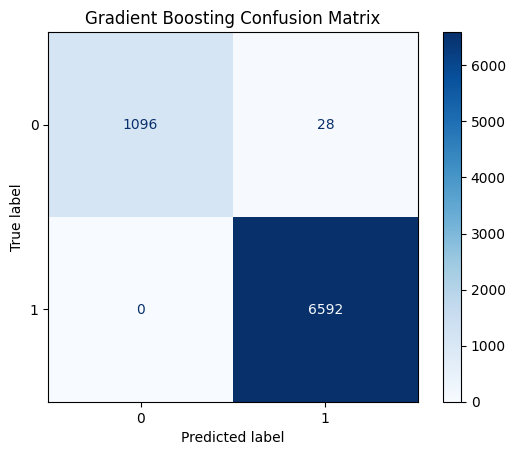

Gradient Boosting Accuracy: 1.00
Top 10 Features for Gradient Boosting: Index(['loan_amnt', 'funded_amnt', 'installment', 'emp_length', 'annual_inc',
       'delinq_2yrs', 'pub_rec', 'total_rec_prncp', 'total_rec_late_fee',
       'recoveries'],
      dtype='object')


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE

# Gradient Boosting with RFE
gb_model = GradientBoostingClassifier(random_state=42)
rfe_gb = RFE(estimator=gb_model, n_features_to_select=10)
rfe_gb.fit(X_train_resampled, y_train_resampled)
y_pred_gb = rfe_gb.predict(X_test)

# Confusion Matrix and Accuracy
cm_gb = confusion_matrix(y_test, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
disp_gb.plot(cmap=plt.cm.Blues)
plt.title("Gradient Boosting Confusion Matrix")
plt.show()
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb):.2f}")

# Top 10 Features
top_features_gb = rfe_gb.support_
print("Top 10 Features for Gradient Boosting:", X_train_resampled.columns[top_features_gb])


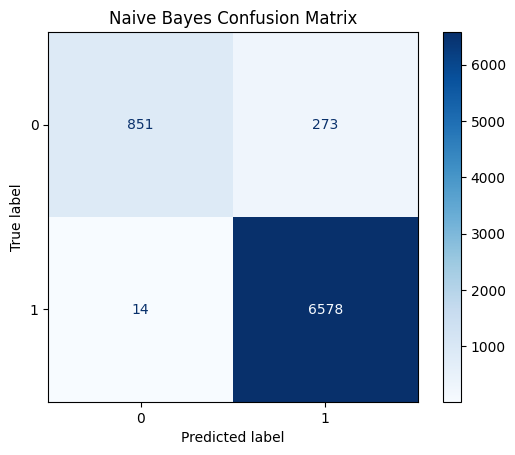

Naive Bayes Accuracy: 0.96
Top 10 Features for Naive Bayes: Index(['term', 'int_rate', 'grade', 'annual_inc', 'inq_last_6mths',
       'revol_util', 'total_rec_prncp', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee'],
      dtype='object')


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif

# Naive Bayes with SelectKBest
skb_nb = SelectKBest(score_func=f_classif, k=10)
X_train_nb = skb_nb.fit_transform(X_train_resampled, y_train_resampled)
X_test_nb = skb_nb.transform(X_test)

nb_model = GaussianNB()
nb_model.fit(X_train_nb, y_train_resampled)
y_pred_nb = nb_model.predict(X_test_nb)

# Confusion Matrix and Accuracy
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb)
disp_nb.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes Confusion Matrix")
plt.show()
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.2f}")

# Top 10 Features
top_features_nb = skb_nb.get_support()
print("Top 10 Features for Naive Bayes:", X_train_resampled.columns[top_features_nb])

